#  Big Data Toolkit and Machine Learning in ArcGIS Pro

- <font size = "3">This demo is inspired by [this](https://www.kaggle.com/c/nyc-taxi-trip-duration/) Kaggle competition, and the data can be download from [here](https://www.kaggle.com/c/nyc-taxi-trip-duration/data).<font>
- <font size = "3">We will be predicting the duration of a NYC taxi trip. We will approach this problem by leveraging arcpy to run a Forest-based Classification and Regression (Spatial Statistics) GeoProcessing task.<font>
- <font size = "3">Topics covered in this demo:<font>
    - Pyspark SQL
    - BDT Spatial Type Functions
    - BDT Processors and Sources
    - ArcPy Feature Classes and Table Views
    - ArcPy ML: Forest-based Classification and Regression
    - Arcgis Spatial Dataframes


### (1) Setup the environment with BDT

<font size = "3">Set filepaths, start a spark instance, create a helper function to track the execution time of certain tasks<font>

- <font size = "3">ArcGIS Notebook needs access to 4 items to run BDT:<font>
    - <font size = "3">[spark-esri](https://github.com/mraad/spark-esri) installed on the active python environment<font>
    - <font size = "3">Path to a BDT .jar file<font>
    - <font size = "3">Path to a BDT Python Bindings .egg file<font>
    - <font size = "3">Path to a valid BDT license .lic file<font>
- <font size = "3">Ensure that ArcGIS Pro is version 2.6<font>
    

In [5]:
import os
from spark_esri import spark_start, spark_stop
from pyspark.sql.functions import pandas_udf, hour, cos, sin, radians, col, when
from pyspark.sql.types import DoubleType, StringType
import matplotlib.pyplot as plt
import pandas as pd
from arcgis.features import GeoAccessor
import numpy as np

%matplotlib inline
plt.style.use('dark_background')

bdt_jarPath = os.path.join("C:", os.sep, "Users", "bdt2", "ws", "DevSummit", "bdt-2.2.0-2.4.5-2.11-SNAPSHOT.jar")
mssql_jarPath = os.path.join("C:", os.sep, "Users", "bdt2", "ws", "DevSummit", "mssql-jdbc-6.4.0.jre8.jar")
bdt_eggPath = os.path.join("C:", os.sep, "Users", "bdt2", "ws", "DevSummit", "bdt-2.2.0-py3.6.egg")
bdt_licPath = os.path.join("C:", os.sep, "Users", "bdt2", "ws", "DevSummit", "ale10305-2021.lic")

spark_stop()

config = {
    "spark.driver.memory": "2G",
    "spark.submit.pyFiles": bdt_eggPath,
    "spark.jars": bdt_jarPath + "," + mssql_jarPath,
    "spark.kryoserializer.buffer.max": "128"
}
spark = spark_start(config=config)

import time
def timeElapsed(startTime):
    endTime = time.perf_counter()
    timeElapsed = endTime - startTime
    if (timeElapsed < 60):
        seconds = endTime - startTime
        print(f"Time Elapsed: {seconds:0.4f} seconds")
    else:
        minutes = (endTime - startTime)/60
        print(f"Time Elapsed: {minutes:0.4f} minutes")  

<font size = "3">Patch the active sparksession with BDT. Confirm Spatial Type Functions have been registered.<font>

In [6]:
import bdt

spark.withBDT(bdt_licPath)

spark.sql("SELECT ST_FromText('POINT(1.0 1.0)') AS wkt").show()

+--------------------+
|                 wkt|
+--------------------+
|[         �?   ...|
+--------------------+



## Part 1: Prepare the Taxi Data For Machine Learning

<font size = "3">Load the taxi kaggle [data](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)<font>

In [7]:
taxiPath = os.path.join("C:", os.sep, "Users", "bdt2", "mnt", "data", "DevSummit", "nyc-taxi-kaggle", "train.csv")

In [8]:
taxi = spark.read.csv(taxiPath,header=True,sep=",")
print(f"Record count: {taxi.count():,}")
taxi.show(5, truncate=True)

Record count: 1,458,644
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19

## Feature Engineering

<font size="3">Enrich the Dataframe with the cosine and sine values of the pickup hour. This captures the cyclic nature of the time.<font>

In [9]:
taxi = taxi.withColumn("pickup_hour", hour("pickup_datetime")) \
           .withColumn("hour_rad", radians(360.0*col("pickup_hour")/23.0)) \
           .withColumn("hour_cos", cos("hour_rad")) \
           .withColumn("hour_sin", sin("hour_rad")).drop("id", "vendor_id","passenger_count","store_and_fwd_flag","hour_rad","pickup_datetime","dropoff_datetime")
taxi.show(5)

+-------------------+------------------+-------------------+------------------+-------------+-----------+--------------------+-------------------+
|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|trip_duration|pickup_hour|            hour_cos|           hour_sin|
+-------------------+------------------+-------------------+------------------+-------------+-----------+--------------------+-------------------+
|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|          455|         17|-0.06824241336467135|-0.9976687691905392|
|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|          663|          0|                 1.0|                0.0|
|-73.979026794433594|40.763938903808594|-74.005332946777344|40.710086822509766|         2124|         11| -0.9906859460363306| 0.1361666490962471|
|-74.010040283203125|   40.719970703125| -74.01226806640625|40.706718444824219|          429|         19|  0.460065037


- <font size="3">Filter the dataframe to only the New York Area<font>
- <font size="3">Filter the trip duration to exclude extreme values. These values are arbitarily defined as trips between 2 and 100 minutes long.<font>


In [10]:
# NYC Extent 
xmin,ymin,xmax,ymax = (-74.2555913638106, 40.496115395209344, -73.70000906387119, 40.91553277600007)

where = " AND ".join([
    f"pickup_longitude between {xmin} and {xmax}",
    f"pickup_latitude between {ymin} and {ymax}",
    f"dropoff_longitude between {xmin} and {xmax}",
    f"dropoff_latitude between {ymin} and {ymax}",
    "trip_duration between 120 and 6000"
])

taxi = taxi.where(where)
taxi.show(5)

+-------------------+------------------+-------------------+------------------+-------------+-----------+--------------------+-------------------+
|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|trip_duration|pickup_hour|            hour_cos|           hour_sin|
+-------------------+------------------+-------------------+------------------+-------------+-----------+--------------------+-------------------+
|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|          455|         17|-0.06824241336467135|-0.9976687691905392|
|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|          663|          0|                 1.0|                0.0|
|-73.979026794433594|40.763938903808594|-74.005332946777344|40.710086822509766|         2124|         11| -0.9906859460363306| 0.1361666490962471|
|-74.010040283203125|   40.719970703125| -74.01226806640625|40.706718444824219|          429|         19|  0.460065037

<font size="3">
Use BDT Spatial Type Function ST_HaversineDistance to enrich the data with the Haversine Distance between the pickup and dropoff locations.
</font>

In [11]:
taxi.createOrReplaceTempView("taxi")
taxi = spark.sql(""" 
    SELECT 
        *, 
        ST_HaversineDistance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)*1000 as meters
    FROM
        taxi""") \

taxi.show(5)

+-------------------+------------------+-------------------+------------------+-------------+-----------+--------------------+-------------------+------------------+
|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|trip_duration|pickup_hour|            hour_cos|           hour_sin|            meters|
+-------------------+------------------+-------------------+------------------+-------------+-----------+--------------------+-------------------+------------------+
|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|          455|         17|-0.06824241336467135|-0.9976687691905392|1498.5207796474772|
|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|          663|          0|                 1.0|                0.0|1805.5071687958239|
|-73.979026794433594|40.763938903808594|-74.005332946777344|40.710086822509766|         2124|         11| -0.9906859460363306| 0.1361666490962471| 6385.098495252941|
|-74

## Data Exploration & Visualization

In [12]:
taxi.createOrReplaceTempView("taxi")

### Plot 1: Average meters traveled for a taxi trip, binned by pickup hour

<Figure size 432x288 with 0 Axes>

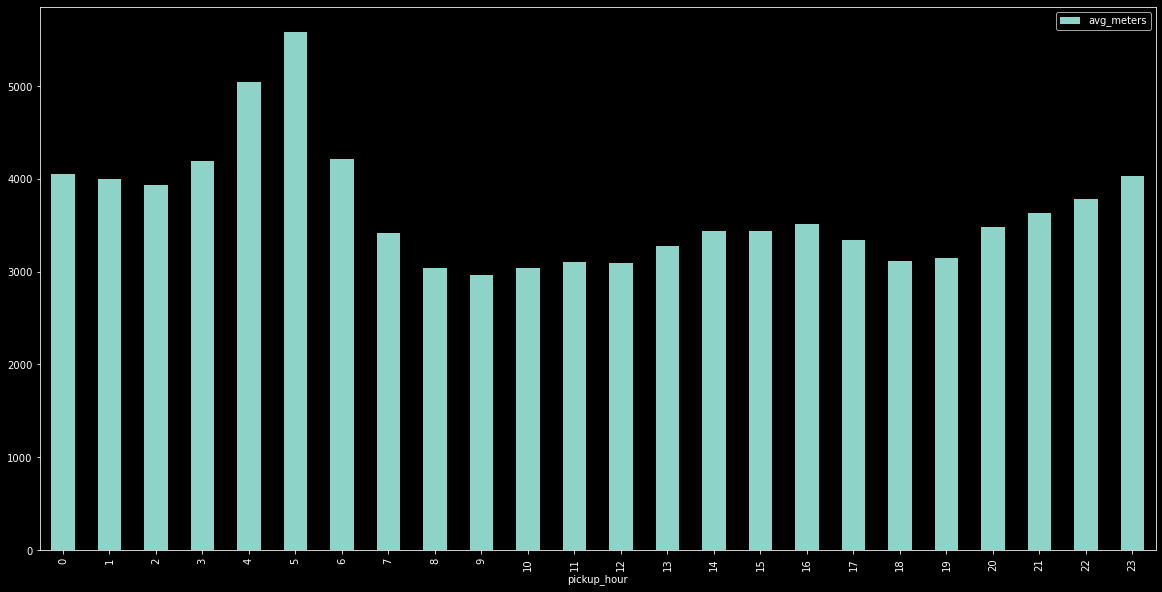

In [13]:
rows = spark.sql(f"""
    SELECT 
        pickup_hour, AVG(meters) as avg_meters
    FROM
        taxi
    GROUP BY
        pickup_hour
    ORDER BY 
        pickup_hour
""")\
    .collect()

pdf = pd.DataFrame(rows,columns=['pickup_hour','avg_meters'])

plt.clf(); # Clear figure
pdf.plot(x='pickup_hour',y='avg_meters',kind='bar',figsize=(20,10));
plt.show();

### Plot 2: Total count of taxi trips, binned by pickup hour

<Figure size 432x288 with 0 Axes>

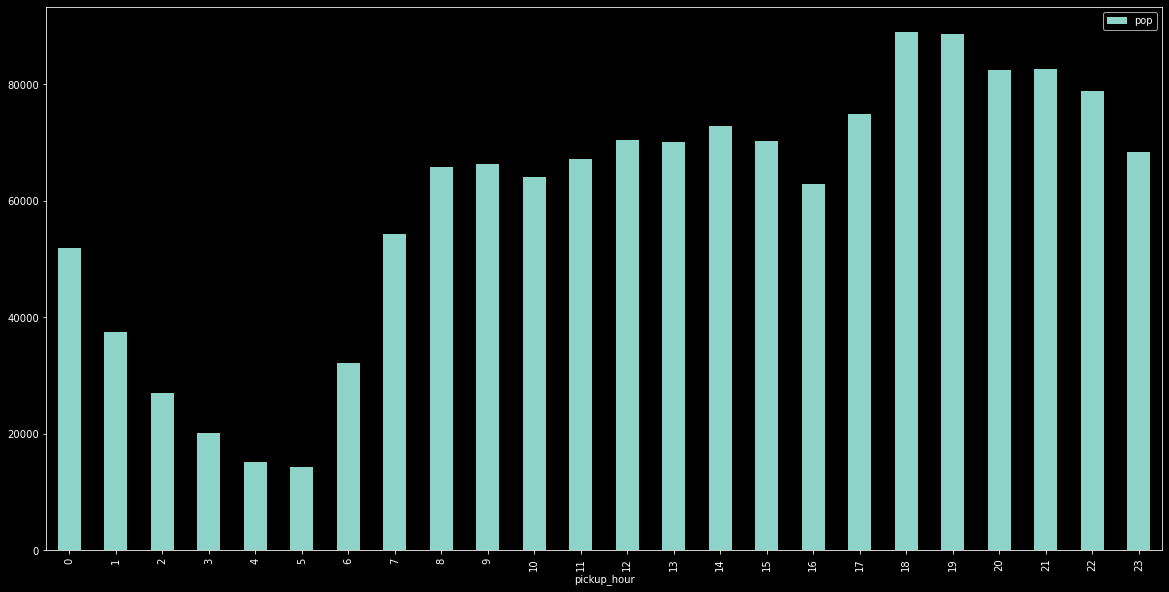

In [14]:
rows = spark.sql(f"""
    SELECT 
        pickup_hour, COUNT(1) as pop
    FROM 
        taxi
    GROUP BY 
        pickup_hour
    ORDER BY 
        pickup_hour
""")\
    .collect()

pdf = pd.DataFrame(rows,columns=['pickup_hour','pop'])

plt.clf()
ax = pdf.plot(x='pickup_hour',y='pop',kind='bar',figsize=(20,10))
plt.show()

### Plot 3: Total count of taxi trips, binned by log(duration)
- <font size="3">The distribution is roughly log-normal</font>

<Figure size 432x288 with 0 Axes>

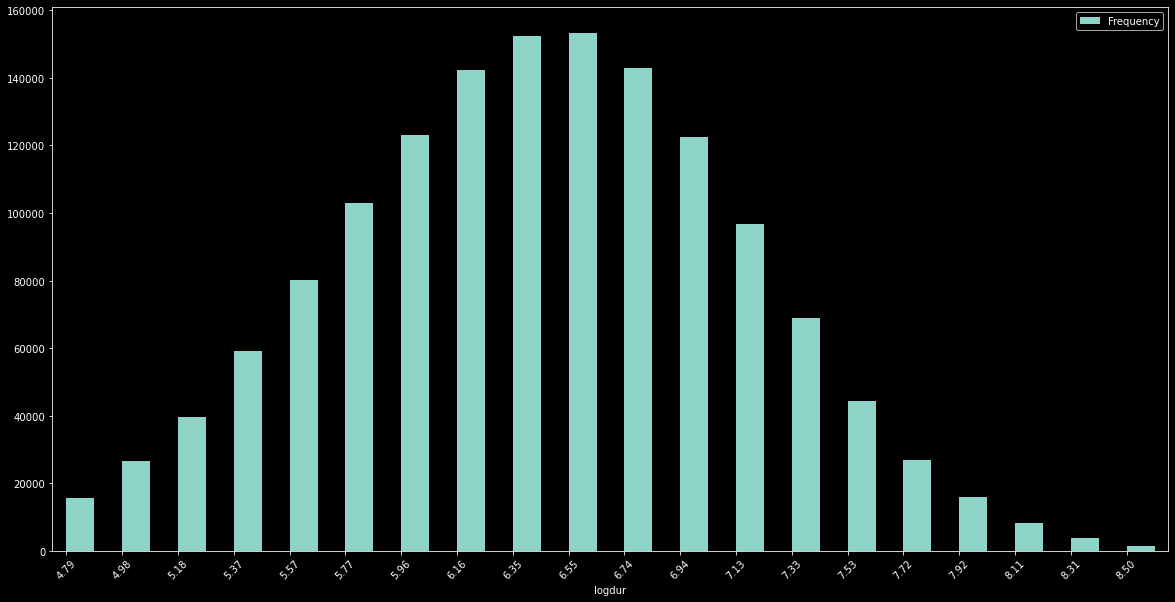

In [15]:
values,counts = taxi \
    .selectExpr('log(trip_duration)')\
    .rdd\
    .flatMap(lambda x:x)\
    .histogram(20)

labels = [format(v,'.2f') for v in values]

plt.clf()
ax = pd.DataFrame(list(zip(labels,counts)),columns=['logdur','Frequency'])\
    .set_index('logdur')\
    .plot(kind='bar', figsize=(20,10), align='edge', rot=45)
plt.show()

### Feature Engineering, Cont.

 - <font size="3">Rename the columns for convenience<font>
 - <font size="3">Convert location data to double values<font>
 - <font size="3">Filter the data by the newly added meters per second column<font> 
 

In [16]:
from pyspark.sql.functions import monotonically_increasing_id

newNames = ['pLon', 'pLat', 'dLon', 'dLat', 'duration', 'hour', 'hourCos', 'hourSin', 'meters']
taxi = taxi.toDF(*newNames)

taxi = taxi.withColumn("pLon", col("pLon").cast(DoubleType())) \
                    .withColumn("pLat", col("pLat").cast(DoubleType())) \
                    .withColumn("dLon", col("dLon").cast(DoubleType())) \
                    .withColumn("dLat", col("dLat").cast(DoubleType())) \
                    .withColumn("duration", col("duration").cast(DoubleType())) \
                    .withColumn("hour", col("hour").cast(DoubleType())) \
                    .withColumn("mps", col("meters")/col("duration")) \
                    .filter("mps BETWEEN 0.5 AND 20")
taxi.printSchema()
taxi.show(5)

root
 |-- pLon: double (nullable = true)
 |-- pLat: double (nullable = true)
 |-- dLon: double (nullable = true)
 |-- dLat: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- hour: double (nullable = true)
 |-- hourCos: double (nullable = true)
 |-- hourSin: double (nullable = true)
 |-- meters: double (nullable = true)
 |-- mps: double (nullable = true)

+------------------+------------------+------------------+------------------+--------+----+--------------------+-------------------+------------------+------------------+
|              pLon|              pLat|              dLon|              dLat|duration|hour|             hourCos|            hourSin|            meters|               mps|
+------------------+------------------+------------------+------------------+--------+----+--------------------+-------------------+------------------+------------------+
| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|   455.0|17.0|-0.0682424133646713

## Part 2

 - <font size ="3">We will augment the kaggle taxi data with NYC Zipcode data for dropoff and pickup locations. The goal is to add region-level data (less granularity) for the model to train on.<font>

### Load in NYC Zipcode Data

- <font size="3">Load in WKT data using BDT SourceGeneric<font>
- <font size="3">ST_FromText will convert the WKT values into Shape Structs, the internal geometry objects of BDT<font>   

In [17]:
countiesWKTPath = os.path.join("C:", os.sep, "Users", "bdt2", "mnt", "data", "DevSummit", "zipcodes", "zip.wkt")

formaty = "csv"
options = {
   "path": countiesWKTPath,
   "header": "true",
   "delimiter": "\t",
   "inferSchema": "true"}

startTime = time.perf_counter()
zipcode = spark.bdt.sourceGeneric(formaty, options, selectExpr=["ID", "NAME", "RG_NAME", "ST_FromText(wkt) as __SHAPE__"], geometryType = "Polygon", wkid=4326, shapeField = "__SHAPE__")
timeElapsed(startTime)

zipcode = zipcode.where("RG_NAME == 'New York'")
print(f"Record count: {zipcode.count():,}")
zipcode.show(10)

Time Elapsed: 0.5422 seconds
Record count: 246
+-----+--------+--------+--------------------+
|   ID|    NAME| RG_NAME|           __SHAPE__|
+-----+--------+--------+--------------------+
|10001|New York|New York|[          ...|
|10002|New York|New York|[          ...|
|10003|New York|New York|[          ...|
|10004|New York|New York|[          ...|
|10005|New York|New York|[          ...|
|10006|New York|New York|[          ...|
|10007|New York|New York|[          ...|
|10009|New York|New York|[          ...|
|10010|New York|New York|[          ...|
|10011|New York|New York|[          ...|
+-----+--------+--------+--------------------+
only showing top 10 rows



### Joining the Taxi Data with the Zipcode Data

- <font size="3">We will use ProcessorAddShapeFromXY to add a point Shape Struct to the taxi data<font>
- <font size="3">We will use ProcessorPointInPolygon twice: First to enrich each taxi record with the NYC Zipcode information of the dropoff location, and then the pickup location<font>
- <font size="3">Uncessary intermediate columns are removed, and column data types are changed<font>
- <font size="3">Three new columns are added: <font>
    - <font size="3">pRegionID: ID of pickup Zipcode <font>
    - <font size="3">dRegionID: ID of dropoff Zipcode <font>
    - <font size="3">oneRegion: Whether the entire taxi trip was in one region or not <font>

In [18]:
startTime = time.perf_counter()

taxiShp = spark.bdt.processorAddShapeFromXY(taxi, "pLon", "pLat", keep=True)

pipped = spark.bdt.processorPointInPolygon(taxiShp, zipcode, cellSize=1.0, emitPippedOnly=True, pointShapeField="__SHAPE__", polygonShapeField="__SHAPE__")

taxi = pipped.withColumnRenamed("ID", "pRegionID") \
                 .drop("RG_NAME") \
                 .drop("NAME") \
                 .drop("__SHAPE__")
taxi.show(5)
timeElapsed(startTime)

+------------------+------------------+------------------+------------------+--------+----+-------------------+-------------------+-----------------+------------------+---------+
|              pLon|              pLat|              dLon|              dLat|duration|hour|            hourCos|            hourSin|           meters|               mps|pRegionID|
+------------------+------------------+------------------+------------------+--------+----+-------------------+-------------------+-----------------+------------------+---------+
|-74.01004028320312|   40.719970703125|-74.01226806640625| 40.70671844482422|   429.0|19.0| 0.4600650377311516|-0.8878852184023756|1485.498422771006|3.4627002861795013|    10013|
|-74.00398254394531|  40.7130126953125|-73.97919464111328| 40.74992370605469|  1317.0| 9.0|-0.7757112907044199| 0.6310879443260526|4605.201075572882| 3.496735820480548|    10007|
|-74.00550079345703| 40.70658874511719| -73.9858169555664| 40.74420166015625|  1022.0|19.0| 0.46006503773

In [19]:
startTime = time.perf_counter()

taxiShp2 = spark.bdt.processorAddShapeFromXY(taxi, "dLon", "dLat", keep=True)

pipped2 = spark.bdt.processorPointInPolygon(taxiShp2, zipcode, cellSize=1.0, emitPippedOnly=True, pointShapeField="__SHAPE__", polygonShapeField="__SHAPE__")

taxi = pipped2.withColumnRenamed("ID", "dRegionID") \
                 .drop("RG_NAME") \
                 .drop("NAME") \
                 .drop("__SHAPE__") \
                 .withColumn("oneRegion", when(col("pRegionID") == col("dRegionID"), "true").otherwise("false")) \
                 .withColumn("pRegionID", col("pRegionID").cast(StringType())) \
                 .withColumn("dRegionID", col("dRegionID").cast(StringType())) \
                 .select(*["duration", "pLon", "pLat", "dLon", "dLat", "hourCos", "hourSin", "meters", "pRegionID", "dRegionID", "oneRegion"])

taxi.show(5)
timeElapsed(startTime)

+--------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+---------+---------+---------+
|duration|              pLon|             pLat|              dLon|              dLat|            hourCos|            hourSin|            meters|pRegionID|dRegionID|oneRegion|
+--------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+---------+---------+---------+
|   429.0|-74.01004028320312|  40.719970703125|-74.01226806640625| 40.70671844482422| 0.4600650377311516|-0.8878852184023756| 1485.498422771006|    10013|    10004|    false|
|   512.0|-74.00180053710938|40.72613525390625|-74.00715637207031|40.740806579589844|-0.9906859460363308|-0.1361666490962464| 1692.642538820824|    10012|    10014|    false|
|   174.0| -74.0063247680664|40.73339080810547|-74.00000762939453|40.743255615234375|-0.3348796121709864|-0.9422609221188204|

<font size="3">Use BDT ProcessorWebMercator to convert WGS84 Lat/Lon values to WebMercator X/Y values in meters<font>

In [20]:
taxi = spark.bdt.processorWebMercator(taxi, "pLat", "pLon") \
                   .withColumnRenamed("X", "SHAPE@X") \
                    .withColumnRenamed("Y", "SHAPE@Y") 
taxi.printSchema()
taxi.show(5)

root
 |-- duration: double (nullable = true)
 |-- pLon: double (nullable = true)
 |-- pLat: double (nullable = true)
 |-- dLon: double (nullable = true)
 |-- dLat: double (nullable = true)
 |-- hourCos: double (nullable = true)
 |-- hourSin: double (nullable = true)
 |-- meters: double (nullable = true)
 |-- pRegionID: string (nullable = true)
 |-- dRegionID: string (nullable = true)
 |-- oneRegion: string (nullable = false)
 |-- SHAPE@X: double (nullable = true)
 |-- SHAPE@Y: double (nullable = true)

+--------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+---------+---------+---------+------------------+------------------+
|duration|              pLon|             pLat|              dLon|              dLat|            hourCos|            hourSin|            meters|pRegionID|dRegionID|oneRegion|           SHAPE@X|           SHAPE@Y|
+--------+------------------+-----------------+------------------+

## Part 3: ML

<font size="3">Split the data into Train and Test datasets. The validation dataset will be taken from the Train dataset in the model creation step.<font>

In [21]:
taxiTrain, taxiTest = taxi.randomSplit([0.85, 0.15])

### Put all of the data from Train and Test Pyspark Dataframes into Feature Classes
- <font size="3">Collect all the dataframe rows and insert them into a new Feature Class<font>
- <font size="3">Table Views for both the Train and Test Feature Classes will be automatically created in the environment<font>
    

In [22]:
trainRows = taxiTrain.collect()

# The Scratch GDB environment setting is the location of a file geodatabase you can use to write temporary data.
# C:\Users\<user_name>\AppData\Local\Temp\1\scratch.gdb.
startTime = time.perf_counter()
ws = arcpy.env.scratchGDB  # Forest GP cannot accept memory based ws :-(
nm = "Train"


fields = [f.name for f in taxiTrain.schema.fields]
fieldsTypes = [(f.name, f.dataType.simpleString().upper()) for f in taxiTrain.schema.fields]

fc = os.path.join(ws, nm)

arcpy.management.Delete(fc)

sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws, nm, "POINT", spatial_reference=sp_ref)
for name, dType in fieldsTypes[:-2]:
    arcpy.management.AddField(fc, name, dType)

with arcpy.da.InsertCursor(fc, fields) as cursor:
    for row in trainRows:
        cursor.insertRow(row)
timeElapsed(startTime)

Time Elapsed: 53.8707 seconds


In [23]:
testRows = taxiTest.collect()

# The Scratch GDB environment setting is the location of a file geodatabase you can use to write temporary data.
# C:\Users\<user_name>\AppData\Local\Temp\1\scratch.gdb.
startTime = time.perf_counter()
ws = arcpy.env.scratchGDB  # Forest GP cannot accept memory based ws :-(
nm = "Test"


fields = [f.name for f in taxiTest.schema.fields]
fieldsTypes = [(f.name, f.dataType.simpleString().upper()) for f in taxiTest.schema.fields]

fc = os.path.join(ws, nm)

arcpy.management.Delete(fc)

sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws, nm, "POINT", spatial_reference=sp_ref)
for name, dType in fieldsTypes[:-2]:
    arcpy.management.AddField(fc, name, dType)

with arcpy.da.InsertCursor(fc, fields) as cursor:
    for row in testRows:
        cursor.insertRow(row)
timeElapsed(startTime)

Time Elapsed: 14.2621 seconds


### Run Forest Based Regression on the Feature Class
- <font size="3">Details about the Random Forest tool can be found [here](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoanalytics-desktop/forest-based-classification-and-regression.htm)<font>

In [25]:
startTime = time.perf_counter()

predictionType = "TRAIN_AND_PREDICT"
trainingTV = "Train"
trainedFC = os.path.join(arcpy.env.scratchGDB,"Trained")
variablePredict = "duration"
categorical = False
explanatoryVariables = [["pLon", "false"], ["pLat", "false"], ["dLon", "false"], ["dLat", "false"], ["hourCos", "false"], ["hourSin", "false"], ["meters", "false"], ["oneRegion", "true"]]
importanceFC = os.path.join(arcpy.env.scratchGDB, "Importance")
predictionTV = "Test"
predictionFC = os.path.join(arcpy.env.scratchGDB, "Predictions")
predictionMatches = [["pLon", "pLon"], ["pLat", "pLat"], ["dLon", "dLon"], ["dLat", "dLat"], ["hourCos", "hourCos"], ["hourSin", "hourSin"], ["meters", "meters"], ["oneRegion", "oneRegion"]]
numTrees=200
minLeafSize=5
maxTreeDepth=5
validationPercentage=18

results = arcpy.gapro.Forest(
    prediction_type=predictionType,
    in_features=trainingTV,
    output_trained_features=trainedFC,
    variable_predict=variablePredict,
    treat_variable_as_categorical=categorical,
    explanatory_variables=explanatoryVariables,
    features_to_predict=predictionTV,
    variable_of_importance=importanceFC,
    output_predicted=predictionFC,
    explanatory_variable_matching=predictionMatches,
    number_of_trees=numTrees,
    minimum_leaf_size=minLeafSize,
    maximum_tree_depth=maxTreeDepth,
    percentage_for_validation=validationPercentage)
print(timeElapsed(startTime))
results

Time Elapsed: 2.2869 minutes
None


id,value
0,C:\Users\bdt2\Documents\ArcGIS\Projects\DevSummit\scratch.gdb\Trained
1,C:\Users\bdt2\Documents\ArcGIS\Projects\DevSummit\scratch.gdb\Importance
2,C:\Users\bdt2\Documents\ArcGIS\Projects\DevSummit\scratch.gdb\Predictions


### Model Performance on Test Data (R^2)

- <font size= "3">Use the arcgis library to load the Predicitons Feature Class into a [Spatial Dataframe](https://github.com/mraad/spark-esri)<font>

In [26]:
sdf = GeoAccessor.from_featureclass(os.path.join(arcpy.env.scratchGDB, "Predictions"))
display(sdf)
actual = sdf["duration"].to_numpy()
prediction = sdf["duration_predicted"].to_numpy()

correlation_matrix = np.corrcoef(actual, prediction)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

,OBJECTID1,OBJECTID,duration,pLon,pLat,dLon,dLat,hourCos,hourSin,meters,pRegionID,dRegionID,oneRegion,duration_predicted,SHAPE
0,1,1,120.0,-74.015007,40.709900,-74.010040,40.721409,-0.068242,0.997669,1346.458579,10280,10013,false,516.824928,"{""x"": -8239312.8924, ""y"": 4969645.6752, ""spati..."
1,2,2,120.0,-74.014732,40.709846,-74.013367,40.714924,0.682553,-0.730836,576.191110,10280,10007,false,498.041582,"{""x"": -8239282.317600001, ""y"": 4969637.8323, ""..."
2,3,3,120.0,-74.009598,40.714790,-74.005226,40.720016,-0.990686,-0.136167,688.073684,10007,10013,false,525.973882,"{""x"": -8238710.738500001, ""y"": 4970363.8888000..."
3,4,4,120.0,-74.006554,40.714939,-74.013580,40.715218,-0.334880,0.942261,593.028196,10007,10282,false,476.930782,"{""x"": -8238371.867699999, ""y"": 4970385.7386000..."
4,5,5,120.0,-74.006325,40.733295,-74.005234,40.736675,-0.576680,0.816970,386.897884,10014,10014,true,385.513468,"{""x"": -8238346.388699999, ""y"": 4973082.0376000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212870,212871,212871,5927.0,-73.985901,40.739441,-73.870750,40.774033,-0.775711,-0.631088,10433.854481,10010,11371,false,1819.501329,"{""x"": -8236072.8116999995, ""y"": 4973984.892399..."
212871,212872,212872,5971.0,-73.776749,40.645580,-73.985580,40.759472,-0.576680,-0.816970,21685.971900,11430,10036,false,3231.197310,"{""x"": -8212790.0929000005, ""y"": 4960204.556900..."
212872,212873,212873,5972.0,-73.716507,40.719639,-73.984329,40.760029,0.962917,-0.269797,23006.705701,11001,10019,false,2033.290291,"{""x"": -8206084.0176, ""y"": 4971075.991999999, ""..."
212873,212874,212874,5983.0,-73.986122,40.757004,-73.790894,40.645523,-0.775711,-0.631088,20603.761436,10036,11430,false,3098.860477,"{""x"": -8236097.441400001, ""y"": 4976565.5781000..."


0.6837737295134211
